In [2]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
username = "neo4j"
password = "password"
driver = GraphDatabase.driver(uri, auth=(username, password))

In [3]:
try:
    with driver.session() as session:
        result = session.run("RETURN 1 AS test")
    print("Connection successful")
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful


In [37]:
import neo4j
import folium
import pandas as pd

findUsers="""
	Match (n:User)-[:REVIEWS]->()
	with n,count(*) as numRevs
	return n.user_id, n.name order by numRevs desc limit 1
"""
user=driver.execute_query(findUsers,database_="neo4j",result_transformer_=neo4j.Result.to_df)
print(f"Trying to locate {user['n.name'][0]}")
print(user['n.user_id'][0])
findLocations="""
	Match (n:User {user_id:$user})-[r:REVIEWS]->(b:Business)
	with [b.longitude,b.latitude] as coordinates, b,r
	return coordinates, r.date, b.city
"""

result_df = driver.execute_query(
    findLocations,
    user=user['n.user_id'][0],
    database_="neo4j",
    result_transformer_=neo4j.Result.to_df
)

coordinates = result_df['coordinates']
result_df['month'] = pd.to_datetime(result_df['r.date']).dt.month
result_df['year'] = pd.to_datetime(result_df['r.date']).dt.year
# Create map centered at the first coordinate
my_map = folium.Map(location=coordinates[0], zoom_start=5)

# Add markers for each coordinate
for lng, lat in coordinates:
	folium.Marker([lat, lng], popup=f"Latitude: {lat}, Longitude: {lng}").add_to(my_map)

# Save the map as an HTML file
my_map.save("multiple_coordinates_map.html")

# Display the map (if in a Jupyter Notebook)
my_map

Trying to locate Michelle
ET8n-r7glWYqZhuR6GcdNw


Looking at the coordinates on the map, see that they form Clusters. These may represent where a person lives/have visited/visits.

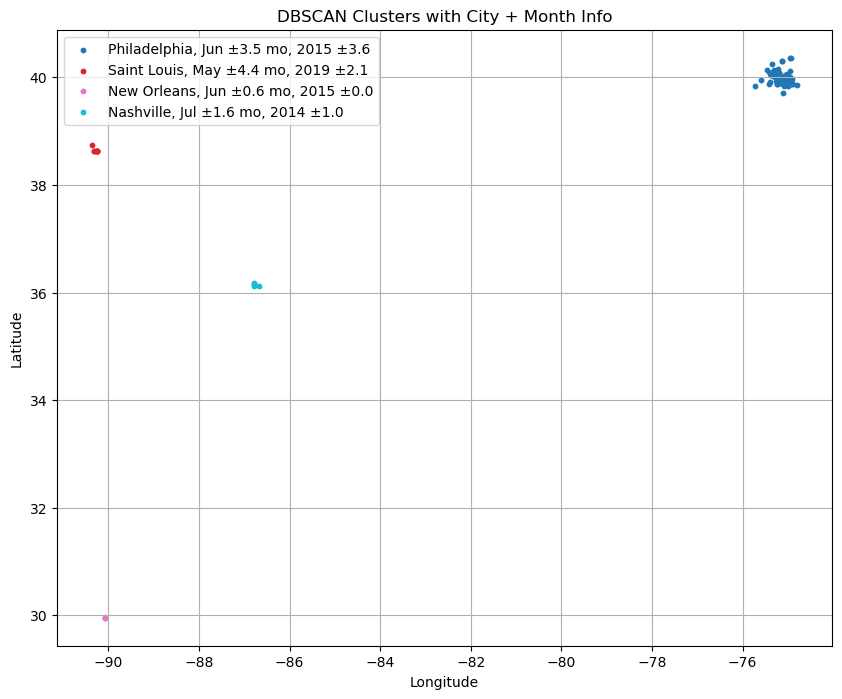

In [39]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from datetime import datetime

X = np.array(coordinates.to_list())

# DBSCAN clustering
dbscan = DBSCAN(eps=1, min_samples=2)
clusters = dbscan.fit_predict(X)

result_df['cluster'] = clusters

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

labels = []
for cluster_id in sorted(result_df['cluster'].unique()):
    if cluster_id == -1:
        labels.append("Noise")
        continue

    group = result_df[result_df['cluster'] == cluster_id]
    
    mode_city = group['b.city'].mode()[0]
    avg_yr = round(group['year'].mean())
    std_yr = group['year'].std()
    avg_month = group['month'].mean()
    std_month = group['month'].std()

    # Convert average month to nearest name
    avg_month_name = month_names[int(round(avg_month)) - 1]
    label = f"{mode_city}, {avg_month_name} ±{std_month:.1f} mo, {avg_yr} ±{std_yr:.1f}"
    labels.append(label)

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))

unique_clusters = sorted(result_df['cluster'].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

for cluster_id, color, label in zip(unique_clusters, colors, labels):
    mask = result_df['cluster'] == cluster_id
    cluster_data = result_df[mask]
    
    if cluster_id == -1:
        plt.scatter(cluster_data['coordinates'].apply(lambda x: x[0]), cluster_data['coordinates'].apply(lambda x: x[1]), c='k', marker='x', label='Noise',s=10)
    else:
        plt.scatter(cluster_data['coordinates'].apply(lambda x: x[0]), cluster_data['coordinates'].apply(lambda x: x[1]), color=color, label=label,s=10)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clusters with City + Month Info')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
Philidelphia=result_df[result_df['cluster'] == 0]
SL=result_df[result_df['cluster'] == 1]
for clust in unique_clusters:
    temp=result_df[result_df['cluster'] == clust]
    numRevs=len(temp)
    print(f"{numRevs} reviews from {temp['b.city'].mode()[0]}, from {temp['year'].min()} to {temp['year'].max()}")


918 reviews from Philadelphia, from 2008 to 2021
8 reviews from Saint Louis, from 2014 to 2020
3 reviews from New Orleans, from 2015 to 2015
5 reviews from Nashville, from 2013 to 2015


This shows the different places that this indindividual has been, and around what time of year.

From the cluster data of year and month, and cluster density shown on graph it can be deduced that this person most likely lives/lived in Philidelphia, since majority of their reviews for businesses are in that city, and over many years, and year round.

The data also suggests that this person visits the Saint Louis area frequently, since they have written reviews in that area over multiple years in that area, at different times of year.

Similarly, due to the small spread in years and months of reviews, we can deduce that this person likely only visited New Orleans once in ~June of 2015 for a short duration of time (maybe around a month). Infact, if you were to zoom in on the map of the area of these New Orleans revies, you see that the following hotels are close to all 3 of these business locations: Hotel Le Maraid, Omni Royal Orleans, The Royal Sonetas New Orleans and Hotel de la Poste - French Quarter are all situated roughly in between the 3 locations, suggesting these are possibly where Michelle was staying at this time.

They likely visited Nashvil multiple times around 2013-15. It is also possible that they lived in Nashvil for a continuous streach sometime from 2013-2015, but the low variance in the time of year of thier reviews suggest otherwise, and (as shown by the code bellow), they were still writing reviews in Philidelphia in those years.

This example shows how the review data for a user may be used to estimate their travel

In [44]:
Philidelphia=result_df[result_df['cluster'] == 0]
SL=result_df[result_df['cluster'] == 1]

print(f"first review from Philidelphia: {Philidelphia['year'].min()}, latest review: {Philidelphia['year'].max()}")
print(f"first review from Philidelphia: {SL['year'].min()}, latest review: {SL['year'].max()}")

for year in range (Philidelphia['year'].min(),Philidelphia['year'].max()+1):
    num_revs=len(Philidelphia[Philidelphia['year']==year])
    print(f"{num_revs} reviews in {year} from Philidelphia")
    
for year in range (SL['year'].min(),SL['year'].max()+1):
    num_revs=len(SL[SL['year']==year])
    print(f"{num_revs} reviews in {year} from Saint Louis")


first review from Philidelphia: 2008, latest review: 2021
first review from Philidelphia: 2014, latest review: 2020
20 reviews in 2008 from Philidelphia
49 reviews in 2009 from Philidelphia
43 reviews in 2010 from Philidelphia
139 reviews in 2011 from Philidelphia
91 reviews in 2012 from Philidelphia
61 reviews in 2013 from Philidelphia
65 reviews in 2014 from Philidelphia
65 reviews in 2015 from Philidelphia
72 reviews in 2016 from Philidelphia
72 reviews in 2017 from Philidelphia
64 reviews in 2018 from Philidelphia
69 reviews in 2019 from Philidelphia
92 reviews in 2020 from Philidelphia
16 reviews in 2021 from Philidelphia
1 reviews in 2014 from Saint Louis
0 reviews in 2015 from Saint Louis
0 reviews in 2016 from Saint Louis
0 reviews in 2017 from Saint Louis
2 reviews in 2018 from Saint Louis
1 reviews in 2019 from Saint Louis
4 reviews in 2020 from Saint Louis
